In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import dask

import matplotlib.pyplot as plt


from tqdm import tqdm
import time
import os
import pickle

import spect
import nb10

import imp
import copy

In [2]:
results_dir = 'nb12v2_results'
#os.makedirs(results_dir)
os.makedirs(results_dir)

In [3]:
def make_submission(ds_pred, message, folderpath):
    df = ds_pred.to_dataframe().unstack()
    df.columns = df.columns.droplevel(None)
    df.columns.name=None
    os.makedirs(f"{results_dir}/{folderpath}")
    df.to_csv(f"{results_dir}/{folderpath}/submission.csv")
    with open(f"{results_dir}/{folderpath}/note.txt", 'w') as f:
        f.write(f"{folderpath}: {message}")
    os.system(f"zip -r {results_dir}/{folderpath}.zip {results_dir}/{folderpath}")
    os.system(f"rm -rf {results_dir}/{folderpath}")

# **Load and proprocess data**

In [4]:
%%time
ds_bin = spect.decode_bins(
    dask.compute(
        xr.open_zarr('../data/temp_binned_1.zarr'), 
        scheduler='threads'
    )[0]
)

CPU times: user 5.88 s, sys: 9.32 s, total: 15.2 s
Wall time: 3.96 s


In [5]:
ds_bin

<xarray.Dataset>
Dimensions:          (sample_id: 1570, temp_bins: 1499, mz: 201, species: 10)
Coordinates:
  * mz               (mz) int64 0 1 2 3 4 5 6 7 ... 194 195 196 197 198 199 200
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
  * temp_bins        (temp_bins) object (0, 1] (1, 2] ... (1498, 1499]
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... nan nan nan
    number_of_obvs   (sample_id, temp_bins, mz) float64 0.0 0.0 0.0 ... nan nan
    split            (sample_id) object 'train' 'train' ... 'test' 'test'
    temp             (sample_id, temp_bins) float64 nan nan nan ... nan nan nan
    time             (sample_id, temp_bins) float64 nan nan nan ... nan nan nan

### Final dataset

In [6]:
np.unique(ds_bin.split.values)

array(['test', 'train', 'val'], dtype=object)

In [7]:
ds_final = ds_bin.where(ds_bin.split!='test', drop=True)
ds_test = ds_bin.where(ds_bin.split!='train', drop=True)

ds_final

<xarray.Dataset>
Dimensions:          (sample_id: 1059, temp_bins: 1499, mz: 201, species: 10)
Coordinates:
  * mz               (mz) int64 0 1 2 3 4 5 6 7 ... 194 195 196 197 198 199 200
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S1057' 'S1058'
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
  * temp_bins        (temp_bins) object (0, 1] (1, 2] ... (1498, 1499]
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    instrument_type  (sample_id) object 'commercial' ... 'commercial'
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    number_of_obvs   (sample_id, temp_bins, mz) float64 0.0 0.0 0.0 ... nan nan
    split            (sample_id) object 'train' 'train' 'train' ... 'val' 'val'
    temp             (sample_id, temp_bins) float64 nan nan nan ... nan nan nan
    time             (sample_id, temp_bins) float64 nan nan nan ... nan nan nan

In [109]:
ds_final.labels.sum(dim='sample_id')/5

<xarray.DataArray 'labels' (species: 10)>
array([24.4, 26.6, 26.4, 46.4,  8.6, 48. , 68.6, 28. , 42.2,  9.8])
Coordinates:
  * species  (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'

# **Model**

In [49]:
imp.reload(nb10)

<module 'nb10' from '/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/nb10.py'>

In [ ]:
ds_train_only = ds_bin.where(ds_bin.split=='train', drop=True)

boosted = nb10.XG2CVsplit(patience=10)
boosted.fit(ds_train_only, folds=8, kfold_random_seed=453689, same_params_all_columns=True, n_trials=30)
boosted.drop_studies()
with open(f'{results_dir}/nb12-model-cv-0.pkl','wb') as f:
    pickle.dump(boosted1, f)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_88409/3716667332.py", line 1, in <module>
    ds_train_only = ds_bin.where(ds_bin.split=='train', drop=True)
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/xarray/core/common.py", line 1276, in where
    self, cond = align(self, cond)
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/xarray/core/alignment.py", line 365, in align
    new_obj = obj.copy(deep=copy)
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/xarray/core/dataset.py", line 1296, in copy
    variables = {k: v.copy(deep=deep) for k, v in self._variables.items()}
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/xarray/core/dataset.py"

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_88409/3716667332.py", line 1, in <module>
    ds_train_only = ds_bin.where(ds_bin.split=='train', drop=True)
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/xarray/core/common.py", line 1276, in where
    self, cond = align(self, cond)
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/xarray/core/alignment.py", line 365, in align
    new_obj = obj.copy(deep=copy)
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/xarray/core/dataset.py", line 1296, in copy
    variables = {k: v.copy(deep=deep) for k, v in self._variables.items()}
  File "/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/xarray/core/dataset.py"

In [55]:
ds_val_only = ds_bin.where(ds_bin.split=='val', drop=True)

In [56]:
val_preds = boosted.predict_proba(ds_val_only, reduce=None)

[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  4.0s


In [59]:
l = nb10.xr_loss(val_preds, ds_val_only.labels)
l.mean(dim=('species')), l.mean().item()

(<xarray.DataArray (split: 8)>
 array([0.15968697, 0.16453102, 0.16435399, 0.16101556, 0.16963331,
        0.16019872, 0.1587725 , 0.15773718])
 Coordinates:
   * split    (split) int64 0 1 2 3 4 5 6 7,
 0.1619911571940335)

In [60]:
l = nb10.xr_loss(val_preds.mean(dim='split'), ds_val_only.labels)
l.mean(dim=('species'))

<xarray.DataArray ()>
array(0.15542296)

In [97]:
imp.reload(nb10)

<module 'nb10' from '/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/nb10.py'>

In [98]:
ds_dummy = ds_train_only.isel(species=slice(0,2))

In [110]:
boosted = nb10.TabNetCVsplit(patience=30)
boosted.fit(ds_dummy, folds=5, kfold_random_seed=453689, same_params_all_columns=True, n_trials=100)
boosted.drop_studies()
with open(f'nb12_results/nb12-model-tabnet-0.pkl','wb') as f:
    pickle.dump(boosted, f)

[I 2022-03-27 10:46:29,387] A new study created in memory with name: no-name-5e5e3031-5cc7-4d61-b1fd-a7fcf3967aa5
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

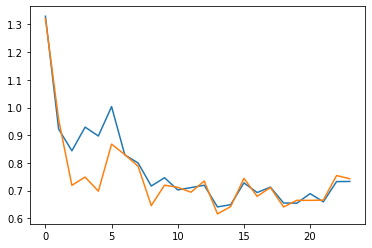

In [94]:
clf = boosted.xgboost[0].models[0]

plt.plot(clf.history['train_logloss'])
plt.plot(clf.history['val_logloss'])

## Ensemble 1

In [ ]:
boosted1 = nb10.XG2CVsplit(patience=10)
boosted1.fit(ds_final, folds=5, kfold_random_seed=987, same_params_all_columns=True, n_trials=100)
boosted1.drop_studies()
with open(f'{results_dir}/nb12-model-cv-1.pkl','wb') as f:
    pickle.dump(boosted1, f)

[I 2022-04-07 22:54:55,679] A new study created in memory with name: no-name-e193e7de-c11b-445b-a092-9d3eb08cdb63
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 189


In [ ]:
77

In [112]:
mean_pred1 = boosted1.predict_proba(ds_test, reduce=None).mean(dim='split')
make_submission(mean_pred1, message="Mean prediction from model 1", folderpath="mean_pred_1")

[########################################] | 100% Completed | 34.6s
[########################################] | 100% Completed | 16.1s
[########################################] | 100% Completed | 15.1s
[########################################] | 100% Completed | 16.1s
[########################################] | 100% Completed | 14.0s
[########################################] | 100% Completed | 17.1s
[########################################] | 100% Completed | 13.1s
[########################################] | 100% Completed | 14.0s
[########################################] | 100% Completed | 10.0s
[########################################] | 100% Completed | 13.0s
updating: nb12_results/mean_pred_1/ (stored 0%)
updating: nb12_results/mean_pred_1/submission.csv (deflated 60%)
updating: nb12_results/mean_pred_1/note.txt (deflated 5%)


## Ensemble 2

In [ ]:
boosted2 = nb10.XG2CVsplit(patience=10)
boosted2.fit(ds_final, folds=5, kfold_random_seed=4532, same_params_all_columns=True, n_trials=100)
boosted2.drop_studies()
with open(f'{results_dir}/nb12-model-cv-2.pkl','wb') as f:
    pickle.dump(boosted2, f)

[I 2022-03-28 22:23:35,501] A new study created in memory with name: no-name-94504357-e752-4e9f-add1-20d000e6f167
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-28 22:32:45,399] Trial 0 finished with value: 0.14828354260044446 and parameters: {'n_estimators': 480, 'learning_rate': 0.031553174473360146, 'max_depth': 8, 'subsample': 0.6442940154925998, 'colsample_bytree': 0.6571370537898951, 'gamma': 0.013519911980226245, 'reg_alpha': 2.0024663189801313, 'reg_lambda': 0.018760206877340174, 'min_child_weight': 0.017799622964677173, 'scale_pos_weight': 18.643830784871486, 'max_delta_step': 5.03425685697581, 'mz_threshold': 127, 'bin_width': 125, 'bin_max': 1260, 'abundance_thresh': 0.0007253681457133148, 'drop_he': True, 'rebase': True, 'maxscale': False, 'logscale': True}. Best is trial 0 with value: 0.14828354260044446.
[I 2022-03-28 22:45:18,270] Trial 1 finished with value: 0.1757149731430171 and parameters: {'n_estimators': 890, 'learning_rate': 0.009177034131474263, 'max_depth': 8, 'subsample': 0.7683315584956165, 'colsample_bytree': 0.8495087035103044, 'gamma': 0.008095740505016814, 'reg_alpha': 0.00010834186299502639, 'reg_lambd

In [12]:
mean_pred2 = boosted2.predict_proba(ds_test, reduce=None).mean(dim='split')
make_submission(mean_pred2, message="Mean prediction from model 2", folderpath="mean_pred_2")

[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  6.2s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  5.0s
[########################################] | 100% Completed |  6.0s
  adding: nb12_results/mean_pred_2/ (stored 0%)
  adding: nb12_results/mean_pred_2/submission.csv (deflated 59%)
  adding: nb12_results/mean_pred_2/note.txt (deflated 5%)


## Ensemble 3

In [ ]:
boosted3 = nb10.XG2CVsplit(patience=10)
boosted3.fit(ds_final, folds=5, kfold_random_seed=98111, same_params_all_columns=True, n_trials=100)
boosted3.drop_studies()
with open(f'{results_dir}/nb12-model-cv-3.pkl','wb') as f:
    pickle.dump(boosted3, f)

[I 2022-03-29 16:42:45,876] A new study created in memory with name: no-name-3b95f26c-c408-458f-b15f-d119b5fdc596
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-29 16:50:34,548] Trial 0 finished with value: 0.2024109933986307 and parameters: {'n_estimators': 670, 'learning_rate': 0.024067721304849656, 'max_depth': 3, 'subsample': 0.9115726836011651, 'colsample_bytree': 0.4586733287298372, 'gamma': 0.017528129620827164, 'reg_alpha': 0.0006218483256329946, 'reg_lambda': 0.007685808874276121, 'min_child_weight': 0.14510082225618195, 'scale_pos_weight': 17.999757413230743, 'max_delta_step': 9.192957057341218, 'mz_threshold': 102, 'bin_width': 199, 'bin_max': 1050, 'abundance_thresh': 1.8323770527464217e-06, 'drop_he': False, 'rebase': False, 'maxscale': True, 'logscale': False}. Best is trial 0 with value: 0.2024109933986307.
[I 2022-03-29 17:06:40,119] Trial 1 finished with value: 0.17186134251838495 and parameters: {'n_estimators': 860, 'learning_rate': 0.006111942235007819, 'max_depth': 5, 'subsample': 0.9939849059964392, 'colsample_bytree': 0.8207308860678996, 'gamma': 0.0010233858645255119, 'reg_alpha': 0.001905093737268531, 'reg_l

In [9]:
mean_pred3 = boosted3.predict_proba(ds_test, reduce=None).mean(dim='split')
make_submission(mean_pred3, message="Mean prediction from model 3", folderpath="mean_pred_3")

[########################################] | 100% Completed |  1min 15.5s
[########################################] | 100% Completed | 43.4s
[########################################] | 100% Completed | 40.5s
[########################################] | 100% Completed | 42.2s
[########################################] | 100% Completed | 35.1s
[########################################] | 100% Completed | 34.4s
[########################################] | 100% Completed | 54.9s
[########################################] | 100% Completed | 40.0s
[########################################] | 100% Completed | 35.4s
[########################################] | 100% Completed | 28.5s
  adding: nb12_results/mean_pred_3/ (stored 0%)
  adding: nb12_results/mean_pred_3/submission.csv (deflated 59%)
  adding: nb12_results/mean_pred_3/note.txt (deflated 5%)


## Ensemble 4

In [ ]:
boosted4 = nb10.XG2CVsplit(patience=10)
boosted4.fit(ds_final, folds=5, kfold_random_seed=6542, same_params_all_columns=True, n_trials=100)
boosted4.drop_studies()
with open(f'{results_dir}/nb12-model-cv-4.pkl','wb') as f:
    pickle.dump(boosted4, f)

[I 2022-03-30 23:25:53,233] A new study created in memory with name: no-name-74e70147-f23f-446f-b1e7-dcb51e4e2c6c
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-30 23:41:55,755] Trial 0 finished with value: 0.13653610131055713 and parameters: {'n_estimators': 640, 'learning_rate': 0.08889773121064948, 'max_depth': 7, 'subsample': 0.730952273343815, 'colsample_bytree': 0.49406931131339077, 'gamma': 0.01248376012540528, 'reg_alpha': 0.0013545289442645598, 'reg_lambda': 0.1736764647518682, 'min_child_weight': 0.006850500624543345, 'scale_pos_weight': 6.813453703267844, 'max_delta_step': 2.808875917331891, 'mz_threshold': 122, 'bin_width': 67, 'bin_max': 880, 'abundance_thresh': 0.0012639542299035164, 'drop_he': False, 'rebase': False, 'maxscale': True, 'logscale': True}. Best is trial 0 with value: 0.13653610131055713.
[I 2022-03-30 23:56:27,225] Trial 1 finished with value: 0.27533890683262774 and parameters: {'n_estimators': 730, 'learning_rate': 0.09032709464815795, 'max_depth': 4, 'subsample': 0.8990188418095564, 'colsample_bytree': 0.7517029808858084, 'gamma': 0.09804303798333633, 'reg_alpha': 0.084317223362031, 'reg_lambda': 0.00

In [10]:
mean_pred4 = boosted4.predict_proba(ds_test, reduce=None).mean(dim='split')
make_submission(mean_pred4, message="Mean prediction from model 4", folderpath="mean_pred_4")

[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 10.0s
[########################################] | 100% Completed |  9.6s
[########################################] | 100% Completed |  8.0s
[########################################] | 100% Completed |  9.0s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  6.0s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  7.0s
[########################################] | 100% Completed |  7.0s
  adding: nb12_results/mean_pred_4/ (stored 0%)
  adding: nb12_results/mean_pred_4/submission.csv (deflated 59%)
  adding: nb12_results/mean_pred_4/note.txt (deflated 5%)


## Ensemble 5

In [ ]:
boosted5 = nb10.XG2CVsplit(patience=10)
boosted5.fit(ds_final, folds=5, kfold_random_seed=14454, same_params_all_columns=True, n_trials=100)
boosted5.drop_studies()
with open(f'{results_dir}/nb12-model-cv-5.pkl','wb') as f:
    pickle.dump(boosted5, f)

[I 2022-03-31 13:23:51,026] A new study created in memory with name: no-name-d78895ad-3b3c-44e0-87a6-225511ef5b88
/home/s1205782/Datastore/miniconda3/envs/cloud2/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-03-31 13:36:18,810] Trial 0 finished with value: 0.3185497155624073 and parameters: {'n_estimators': 480, 'learning_rate': 0.011805317454709868, 'max_depth': 4, 'subsample': 0.6777073880189728, 'colsample_bytree': 0.4906396968307223, 'gamma': 0.08994381173272262, 'reg_alpha': 0.16711926388695736, 'reg_lambda': 0.12143300959107672, 'min_child_weight': 0.008015534142868107, 'scale_pos_weight': 3.824101678812898, 'max_delta_step': 6.213018330647319, 'mz_threshold': 101, 'bin_width': 57, 'bin_max': 570, 'abundance_thresh': 0.7421634805717768, 'drop_he': True, 'rebase': False, 'maxscale': True, 'logscale': True}. Best is trial 0 with value: 0.3185497155624073.
[I 2022-03-31 13:44:16,979] Trial 1 finished with value: 0.14579151606536356 and parameters: {'n_estimators': 830, 'learning_rate': 0.0446578158982945, 'max_depth': 10, 'subsample': 0.512352840122909, 'colsample_bytree': 0.7911181027530922, 'gamma': 0.01200757915874901, 'reg_alpha': 0.004663867020221162, 'reg_lambda': 2.131336

In [ ]:
mean_pred5 = boosted5.predict_proba(ds_test, reduce=None).mean(dim='split')
make_submission(mean_pred5, message="Mean prediction from model 5", folderpath="mean_pred_5")

## Ensemble 6

In [ ]:
boosted6 = nb10.XG2CVsplit(patience=10)
boosted6.fit(ds_final, folds=5, kfold_random_seed=454, same_params_all_columns=True, n_trials=100)
boosted6.drop_studies()
with open(f'{results_dir}/nb12-model-cv-6.pkl','wb') as f:
    pickle.dump(boosted6, f)

In [13]:
mean_pred6 = boosted6.predict_proba(ds_test, reduce=None).mean(dim='split')
make_submission(mean_pred6, message="Mean prediction from model 6", folderpath="mean_pred_6")

NameError: name 'boosted6' is not defined

### backup

In [14]:
%%bash
cp nb12v2_results/*.pkl nb12v2_results/backup/.

## Ensemble 1-n

In [8]:
models = []
for n in range(1,7):
    with open(f'{results_dir}/nb12-model-cv-{n}.pkl','rb') as f:
        models+=[pickle.load(f)]

In [9]:
{k:[m.params[k] for m in models] for k in models[0].params.keys()}

{'n_estimators': [480, 600, 390, 520, 770, 720],
 'learning_rate': [0.08344637822900948,
  0.060537623351343606,
  0.06085540062012004,
  0.026678712587493172,
  0.1395141681049125,
  0.07002822473221944],
 'max_depth': [6, 10, 4, 6, 4, 4],
 'subsample': [0.7930228254540714,
  0.6641920371038822,
  0.6285293935864247,
  0.7455093396294793,
  0.779053622781086,
  0.7027801327548093],
 'colsample_bytree': [0.643560125099049,
  0.7949422410908208,
  0.5044831868131667,
  0.7131387277149807,
  0.698780392125113,
  0.9718741960760218],
 'gamma': [0.022274136268619675,
  0.15752535126207576,
  0.015312269310480226,
  0.013069775030464258,
  0.012096593882655314,
  0.001496250854437601],
 'reg_alpha': [1.225136069824638,
  0.2627989741696247,
  0.8910699978767024,
  0.0003097249163902716,
  0.003363756222739145,
  0.00015544078467974847],
 'reg_lambda': [0.15740999091373192,
  4.286580110633182,
  0.03470512071066401,
  4.077030182776466,
  0.08666491856639201,
  2.2551750681291094],
 'min_ch

In [10]:
all_preds = []
for m in models:
    all_preds += [m.predict_proba(ds_test, reduce=None)]

[########################################] | 100% Completed | 56.5s
[########################################] | 100% Completed | 54.4s
[########################################] | 100% Completed | 56.9s
[########################################] | 100% Completed | 59.1s
[########################################] | 100% Completed | 59.4s
[########################################] | 100% Completed | 56.5s
[########################################] | 100% Completed | 57.3s
[########################################] | 100% Completed | 55.6s
[########################################] | 100% Completed |  1min  0.8s
[########################################] | 100% Completed | 56.4s
[########################################] | 100% Completed | 47.4s
[########################################] | 100% Completed | 49.9s
[########################################] | 100% Completed | 48.2s
[########################################] | 100% Completed | 51.1s
[########################################]

In [11]:
split = 0
for da in all_preds:
    da['split'] = da.split + split
    split += len(da.split)
all_preds = xr.concat(all_preds, dim='split')

In [12]:
mean_pred_ens1n = all_preds.mean(dim='split')
make_submission(
    mean_pred_ens1n, 
    message=f"Mean prediction from models 1-{len(models)}", 
    folderpath=f"mean_pred_1-{len(models)}"
)

  adding: nb12_results/mean_pred_1-6/ (stored 0%)
  adding: nb12_results/mean_pred_1-6/submission.csv (deflated 59%)
  adding: nb12_results/mean_pred_1-6/note.txt (deflated 7%)


In [13]:
median_pred_ens1n = all_preds.quantile(0.5, dim='split').drop('quantile')
make_submission(
    median_pred_ens1n, 
    message=f"Median prediction from models 1-{len(models)}", 
    folderpath=f"median_pred_1-{len(models)}"
)

updating: nb12_results/median_pred_1-6/ (stored 0%)
updating: nb12_results/median_pred_1-6/submission.csv (deflated 55%)
updating: nb12_results/median_pred_1-6/note.txt (deflated 10%)
